In [1]:
import tensorflow as tf
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\pyth

In [2]:
import matplotlib.pyplot as plt
tf.set_random_seed(1)
np.random.seed(1)

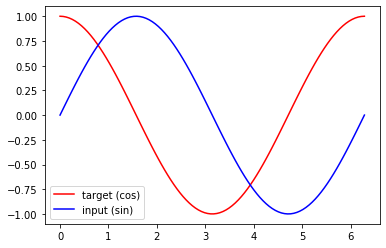

In [3]:
# Hyper Parameters
TIME_STEP = 10       # rnn time step
INPUT_SIZE = 1      # rnn input size
CELL_SIZE = 32      # rnn cell size
LR = 0.02           # learning rate

# show data
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)
x_np = np.sin(steps); y_np = np.cos(steps)    # float32 for converting torch FloatTensor
plt.plot(steps, y_np, 'r-', label='target (cos)'); plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best'); plt.show()

In [4]:
# tensorflow placeholders
tf_x = tf.placeholder(tf.float32, [None, TIME_STEP, INPUT_SIZE])        # shape(batch, 5, 1)
tf_y = tf.placeholder(tf.float32, [None, TIME_STEP, INPUT_SIZE])          # input y

In [5]:
# RNN
with tf.variable_scope('LSTMCell'):
    rnn_cell = tf.nn.rnn_cell.LSTMCell(num_units=CELL_SIZE)
    
with tf.variable_scope('initial_state'):  
    init_s = rnn_cell.zero_state(batch_size=1, dtype=tf.float32)    # very first hidden state

with tf.variable_scope('dynamic_rnn'): 
    outputs, final_s = tf.nn.dynamic_rnn(
        rnn_cell,                   # cell you have chosen
        tf_x,                       # input
        initial_state=init_s,       # the initial hidden state
        time_major=False,           # False: (batch, time step, input); True: (time step, batch, input)
    )
    
outs2D = tf.reshape(outputs, [-1, CELL_SIZE])                       # reshape 3D output to 2D for fully connected layer
net_outs2D = tf.layers.dense(outs2D, INPUT_SIZE)
outs = tf.reshape(net_outs2D, [-1, TIME_STEP, INPUT_SIZE])          # reshape back to 3D

with tf.name_scope('loss'): 
    loss = tf.losses.mean_squared_error(labels=tf_y, predictions=outs)  # compute cost
    tf.summary.scalar('loss', loss)     # add loss to scalar summary
    
with tf.name_scope('train'): 
    train_op = tf.train.AdamOptimizer(LR).minimize(loss)
    
merge_op = tf.summary.merge_all()                       # operation to merge all summary

In [6]:
'''如果你是使用GPU版TensorFlow的話，並且你想在顯卡高佔用率的情況下（比如玩遊戲）訓練模型，
那你要注意在初始化Session的時候為其分配固定數量的顯存，否則可能會在開始訓練的時候直接報錯退出'''

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)  
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) 

In [7]:
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()) # the local var is for accuracy_op
writer = tf.summary.FileWriter('rnn/regression/ ', sess.graph)     # write to file
sess.run(init_op)     # initialize var in graph

In [8]:
saver = tf.train.Saver()  # define a saver for saving and restoring
save_path = 'rnn/regression/model.ckpt'
               
# plt.figure(1, figsize=(12, 5)); plt.ion()       # continuously plot

# for step in range(60):
#     start, end = step * np.pi, (step+1)*np.pi   # time range
#     # use sin predicts cos
#     steps = np.linspace(start, end, TIME_STEP)
#     x = np.sin(steps)[np.newaxis, :, np.newaxis]    # shape (batch, time_step, input_size)
#     y = np.cos(steps)[np.newaxis, :, np.newaxis]
#     if 'final_s_' not in globals():                 # first state, no any hidden state
#         feed_dict = {tf_x: x, tf_y: y}
#     else:                                           # has hidden state, so pass it to rnn
#         feed_dict = {tf_x: x, tf_y: y, init_s: final_s_}
#     _, pred_, final_s_ = sess.run([train_op, outs, final_s], feed_dict)     # train

# #     result = sess.run(merge_op, feed_dict)
# #     writer.add_summary(result, step)
#     saver.save(sess, save_path, global_step=step)
#     # plotting
#     plt.plot(steps, y.flatten(), 'r-'); plt.plot(steps, pred_.flatten(), 'b-')
#     plt.ylim((-1.2, 1.2)); plt.draw(); plt.pause(0.05)

# plt.ioff(); plt.show()


for step in range(60):
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(start, end, TIME_STEP)
    x = np.sin(steps)[np.newaxis, :, np.newaxis]    # shape (batch, time_step, input_size)
    y = np.cos(steps)[np.newaxis, :, np.newaxis]
    if 'final_s_' not in globals():                 # first state, no any hidden state
        feed_dict = {tf_x: x, tf_y: y}
    else:                                           # has hidden state, so pass it to rnn
        feed_dict = {tf_x: x, tf_y: y, init_s: final_s_}
    _, pred_, final_s_ = sess.run([train_op, outs, final_s], feed_dict)     # train
    loss_ = sess.run(loss, feed_dict)     # loss_  
    print(loss_)
    result = sess.run(merge_op, feed_dict)
    writer.add_summary(result, step)
    saver.save(sess, save_path, global_step=step)




0.44186687
0.31768078
0.24414511
0.04802855
0.017521402
0.036764026
0.14181505
0.033855833
0.19088964
0.07558133
0.11550542
0.18487655
0.14897661
0.2544055
0.16650958
0.25873482
0.16319151
0.22882943
0.10949121
0.15478103
0.030960988
0.061883092
0.008346583
0.012162693
0.04136508
0.010518318
0.060304154
0.02230848
0.05717368
0.012503633
0.025535401
0.0015866669
0.0043678023
0.0113501595
0.013763425
0.02274465
0.024371399
0.021894354
0.0224864
0.011082422
0.012997362
0.0021161973
0.004655731
0.0034703568
0.0014407664
0.009879796
0.0040329797
0.012022747
0.0077126822
0.0098662535
0.006168342
0.005830571
0.0023109927
0.0019533099
0.0014944205
0.0009397099
0.0040790355
0.002248559
0.005019063
0.0034708225


# Saver 保存讀取

In [9]:
def save():  
    saver = tf.train.Saver()  # define a saver for saving and restoring
    saver.save(sess, save_path)  # meta_graph is not recommended       

save()

In [10]:
# destroy previous net
tf.reset_default_graph()

def reload():
    print('This is reload')
    with tf.Session() as sess:
        ckpt = tf.train.get_checkpoint_state(os.path.dirname(save_path))       
        if ckpt and ckpt.model_checkpoint_path:
#             print(tf.train.latest_checkpoint('cnn'))            
            print('Found checkpoint, try to restore...')
            saver = tf.train.import_meta_graph(''.join([ckpt.model_checkpoint_path, '.meta']))   
            saver.restore(sess, tf.train.latest_checkpoint(save_path.replace('model.ckpt','')))

            # 列印出網路中可訓練的權重引數名
            for var in tf.trainable_variables():
                print(var)           
reload() 

This is reload
Found checkpoint, try to restore...
INFO:tensorflow:Restoring parameters from rnn/regression/model.ckpt
<tf.Variable 'dynamic_rnn/rnn/lstm_cell/kernel:0' shape=(33, 128) dtype=float32_ref>
<tf.Variable 'dynamic_rnn/rnn/lstm_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(32, 1) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(1,) dtype=float32_ref>


# Reload 後繼續train

In [11]:
# for step in range(60):
#     start, end = step * np.pi, (step+1)*np.pi   # time range
#     # use sin predicts cos
#     steps = np.linspace(start, end, TIME_STEP)
#     x = np.sin(steps)[np.newaxis, :, np.newaxis]    # shape (batch, time_step, input_size)
#     y = np.cos(steps)[np.newaxis, :, np.newaxis]
#     if 'final_s_' not in globals():                 # first state, no any hidden state
#         feed_dict = {tf_x: x, tf_y: y}
#     else:                                           # has hidden state, so pass it to rnn
#         feed_dict = {tf_x: x, tf_y: y, init_s: final_s_}
#     _, pred_, final_s_ = sess.run([train_op, outs, final_s], feed_dict)     # train    
#     loss_ = sess.run(loss, feed_dict)     # loss_    
# #     print(loss_)
#     result = sess.run(merge_op, feed_dict)
#     writer.add_summary(result, step)
#     saver.save(sess, save_path, global_step=step)